In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

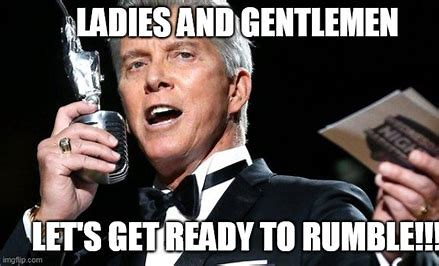

# Transformers Architecture - Code From Scratch 
Hello everybody, glad you landed here. I'm Shresth Shukla. I have been spending past few months learning about AI, ML and Deep Learning. And it surely is a fascianting journey in itself. I'll keep my intro for later, here's what I did to build my foundations in AI space. 

In this notebook my aim is to implement Transformers Architecture from Scratch. We'll go step by step from input embeddings to training and inference. Let's go. Paper Link : https://arxiv.org/pdf/1706.03762.pdf

I assume you have understanding of it's architecture. We'll code it from scratch here but basic understanding is necessary.

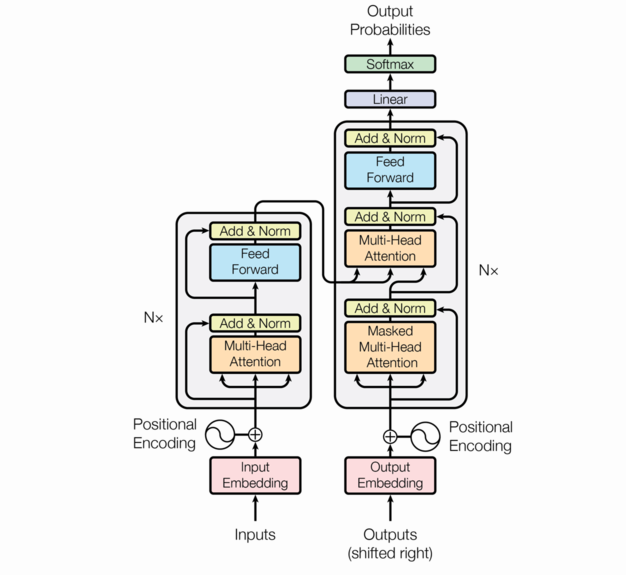

Here's the approach followed while writing this notebook.

1. First we'll create all the necessary items/classes for encoder block.
2. We'll create all the necessary classes or layers needed for decoder block.
3. Then we go towards combining them including Projection Layer and building our complete transformer architecture or model say.

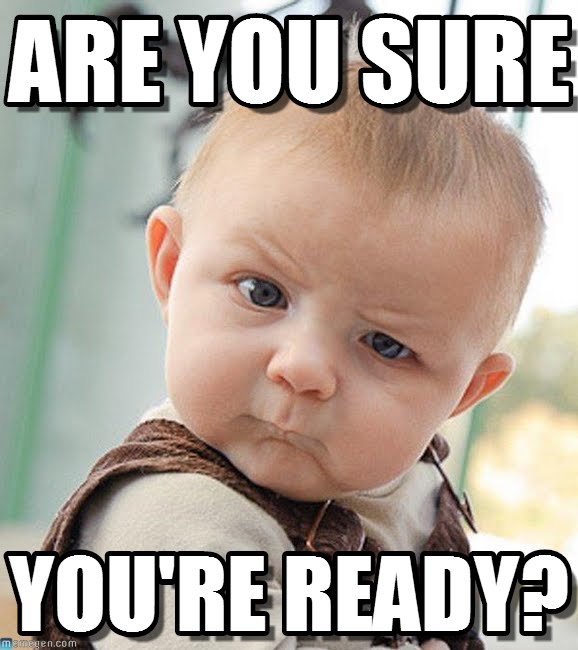

In [76]:
import torch
import torch.nn as nn
import math


/bin/bash: -c: line 0: syntax error near unexpected token `attachment:c52b9559-ab45-4401-976b-66b67d65755b.png'
/bin/bash: -c: line 0: `[image.png](attachment:c52b9559-ab45-4401-976b-66b67d65755b.png)'


# Input Embeddings

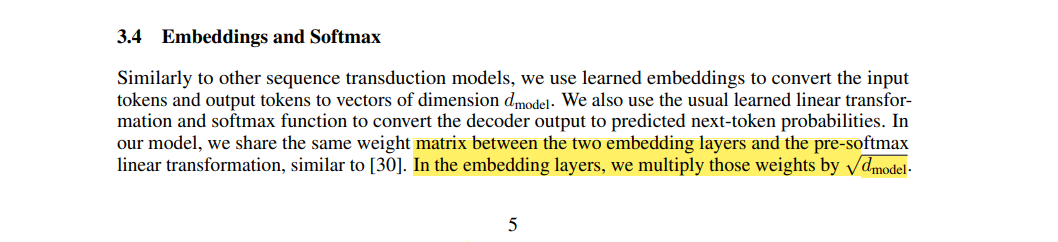

In [62]:
class InputEmbeddings(nn.Module):
    def __init__(self, d_model:int, vocab_size: int):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, d_model) #we provide vocabulary size and dimension of embedding to nn.embedding
        
    
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)
        
        
# Example:
# Try uncommenting and run this code to see what happens at this step.
embed = InputEmbeddings(d_model=512, vocab_size=10000)
sentence = torch.tensor([5, 123, 456, 2,3]) #(Here these numbers represent position of these words in vocabulary. I'm assumming it to be random here)
output = embed(sentence)
print(output.shape)


    

torch.Size([5, 512])


# Positional Enocding

After our words are converted and embedded into vectors, we find positional encoding of these words which convey information about positions of these words in the sentence.

It is of dimension "sequence length" to d_model. If we have 5 words in the sentence then in this case, dimension of our positional encoddings would be (5, 512)

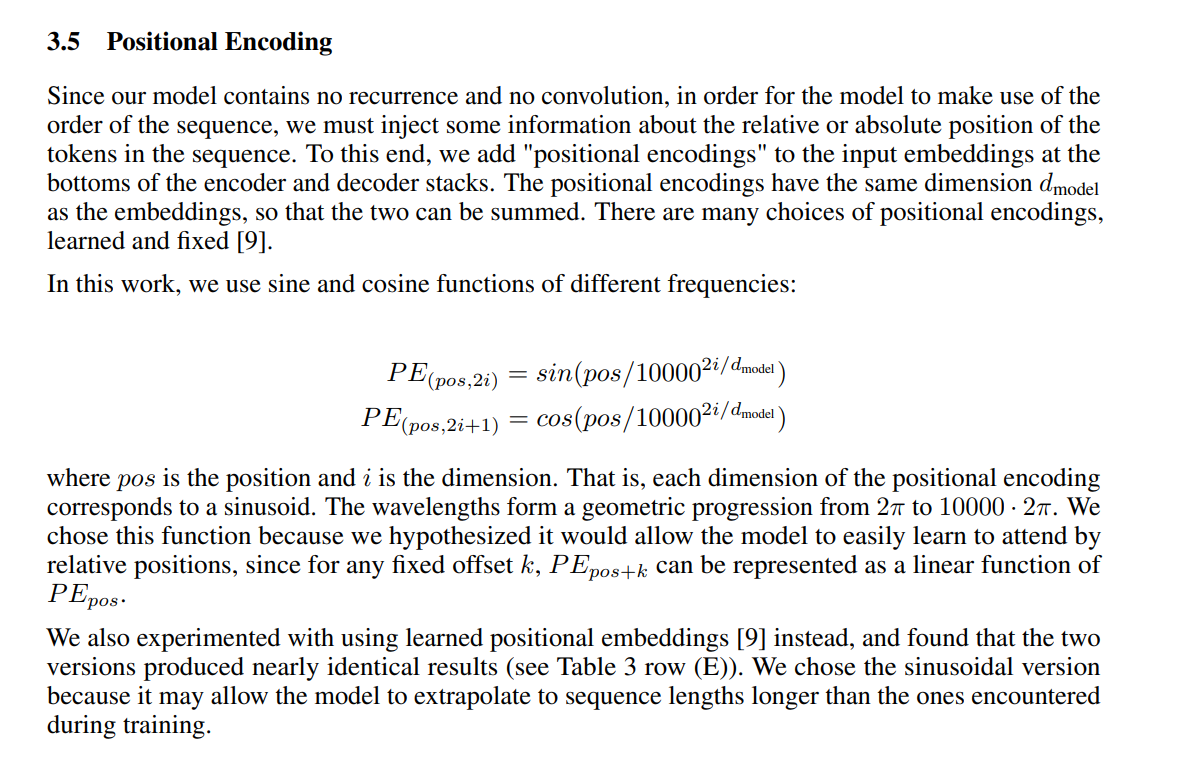

1. We added a drop out layer here.
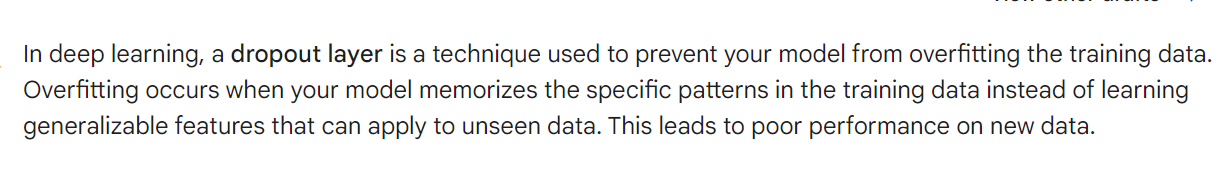
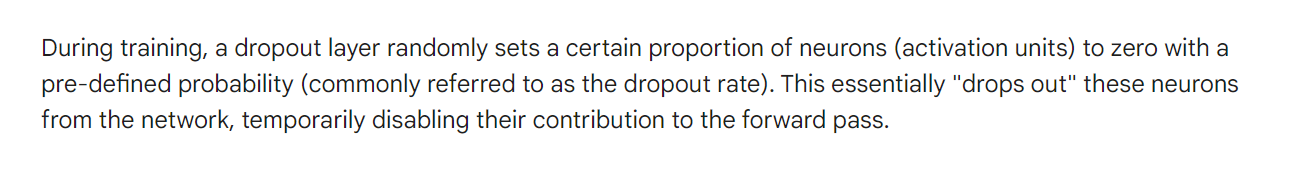



In [63]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model : int, seq_len:int, dropout:float) -> None:
        super().__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.dropout = nn.Dropout(dropout) #it takes values between 0 and 1. 1 means all neurons are dropout. 0 means none. Usually values lies between the range 0.1 to 0.5
    
        #creating a matrix of shape (seq_len, d_model)
        pe = torch.zeros(seq_len, d_model)
        
        position = torch.arange(0, seq_len, dtype = torch.float).unsqueeze(1) #this part is numerator in the formula
        div_term = torch.exp(torch.arange(0, d_model,2).float() *(-math.log(10000.0)/d_model)) #this part is denomminator in the formula. It
        #we find these values in log space. 
        
        #now applying sin and cos to our values
        
        pe[:,0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0) #it'll become a tensor of dimension (1, seq_len, d_model)
        self.register_buffer('pe', pe) #it means our value will be saves when we save the model. We register it as buffer for this purpose.
        
        
    def forward(self,x):
        #we add PE to Embedding
        
        x = x + (self.pe[:, :x.shape[1], :]).requires_grad_(False) #this makes our value fixed and not learned during training.
        return self.dropout(x)
    

    
# Example:
pos_enc = PositionalEncoding(d_model = 512, seq_len = 5, dropout = 0.3)
pos_enc_result  = pos_enc(output)
print(pos_enc_result)

tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,  11.4188],
         [ 16.8504,   0.0000,  42.0654,  ...,   0.0000,  11.8928,  -0.7735],
         [  0.0000,  -0.0000,  -1.2020,  ...,  -8.7979,  23.1765,  -9.8806],
         [ 30.8617,   4.8727,  -0.0000,  ...,  16.2640,  -0.0000, -11.8007],
         [ -0.0000, -17.3741,  59.0882,  ...,   0.0000, -25.6294,   6.9822]]],
       grad_fn=<MulBackward0>)


# Layer Normalization
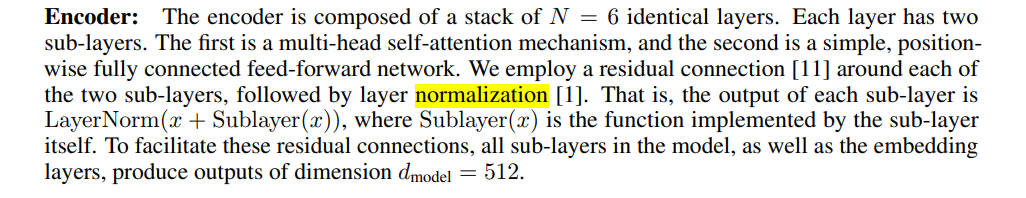

Credits to Jai for Alammar for this picture.
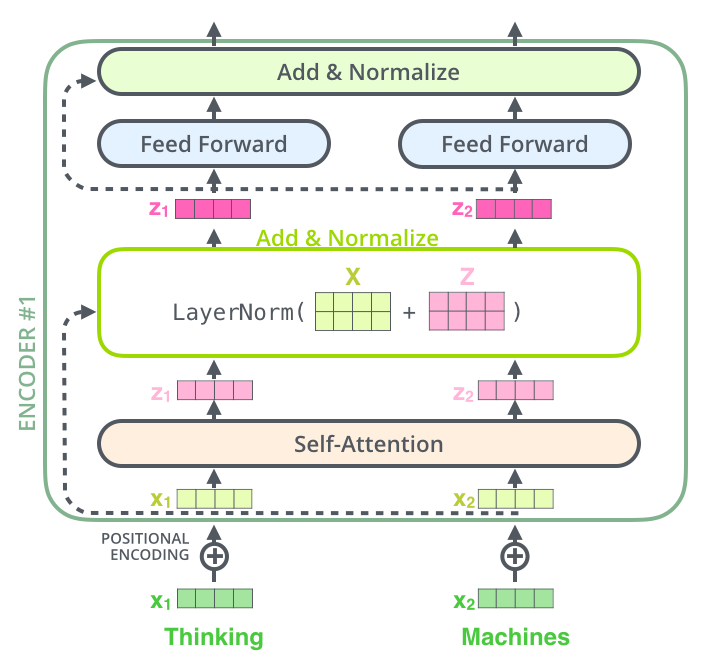

Credits to Umar Jamil for this image and his youtube video which helped me write this notebook.

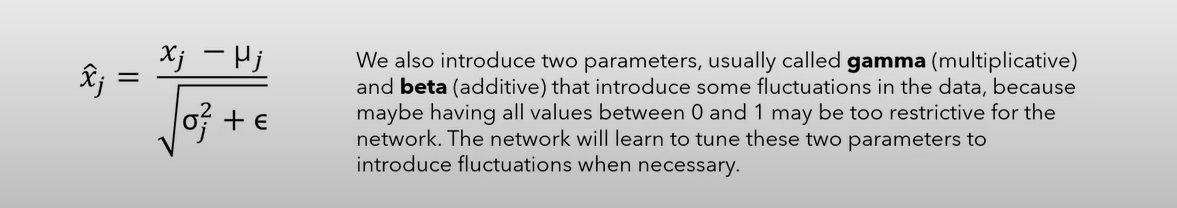

In [64]:
class LayerNormalization(nn.Module):
    def __init__(self, eps: float = 10**-6) -> None:
        super().__init__()
        self.eps = eps
        self.alpha = nn.Parameter(torch.ones(1)) #mutiplied
        self.bias = nn.Parameter(torch.zeros(1)) #added
    
    def forward(self,x):
        mean = x.mean(dim = -1, keepdim = True)
        std = x.std(dim = -1, keepdim = True)
        return self.alpha * (x-mean)/ (std + self.eps) + self.bias


    
#Example to visualize this class: 
# layer = LayerNormalization()
# print(output)
# print(layer(output))
# print(layer.alpha, layer.bias)    

# Feed Forward Layer

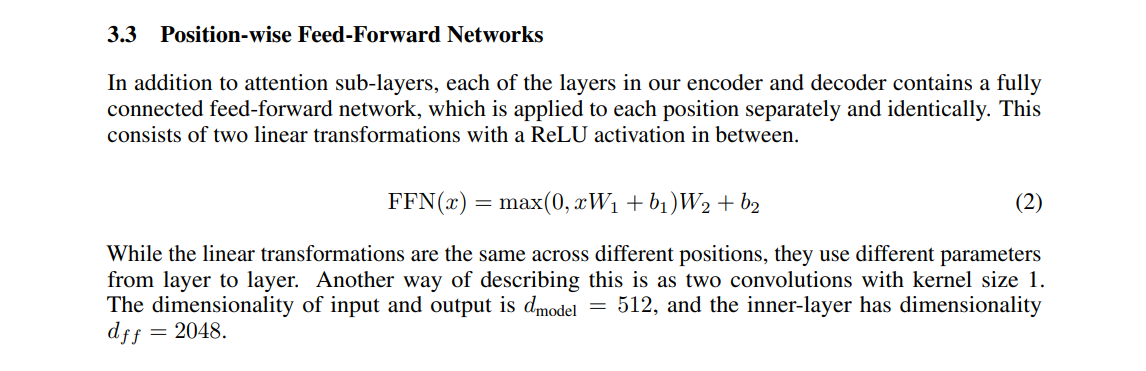

In [65]:
class FeedForwardBlock(nn.Module):
    def __init__(self, d_model: int, d_ff: int, dropout : float) -> None:
        super().__init__()
        self.linear_l = nn.Linear(d_model, d_ff) #here it is W1 and B1
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(d_ff, d_model) #here it is w2 and b2
        
    def forward(self,x):
        #What's happening here is -> it'll transform 
        # (Batch, seq_len, d_model) -> (batch, seq_len, d_ff) in linear_1
        # and from d_ff to d_model back in layer_2. 
        
        return self.linear_2(self.dropout(torch.relu(self.linear_1(x)))) #using the format as described in the image above
        
        


# Muti-Head Attention 

Now comes the most interesting part of our Encoder part. We didn't do it in starting, since I wanted to spend more time onto it. Let's go :)

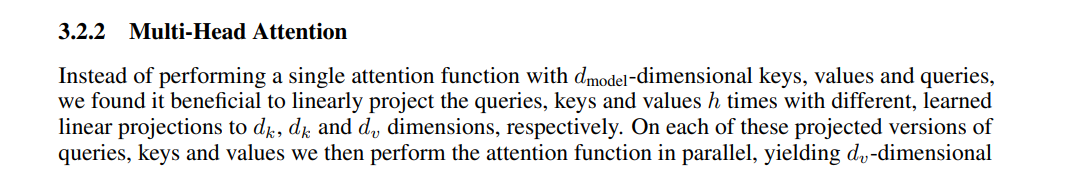
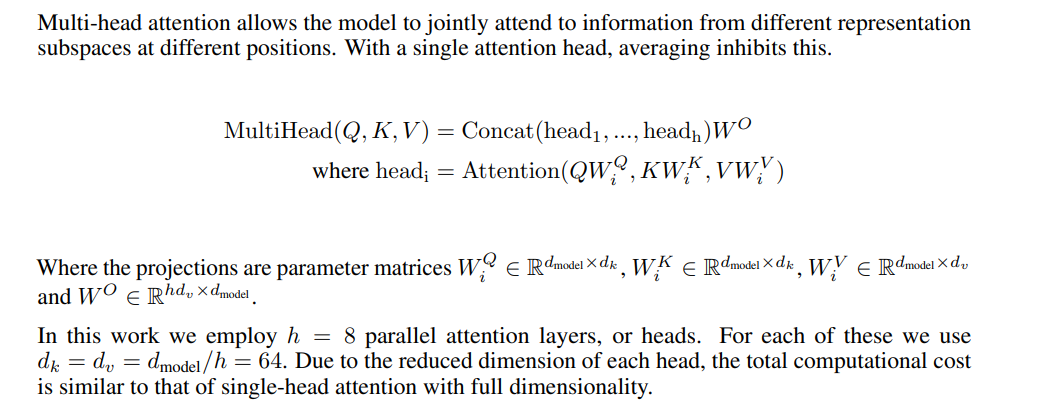

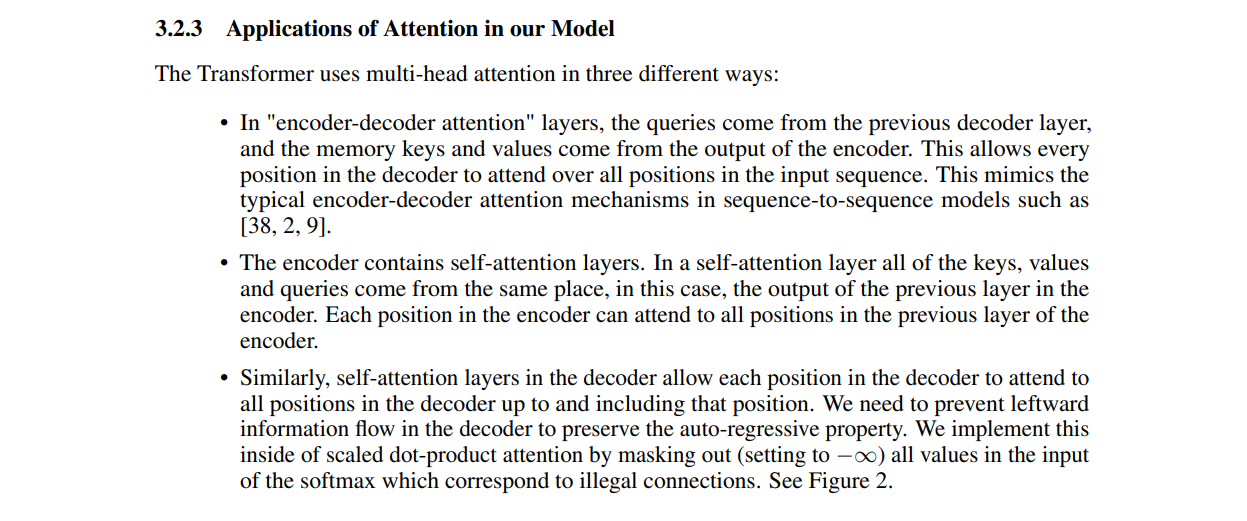

Here's what we do in a single image. I have taken this screenshot from a youtube video by Umar Jamil :

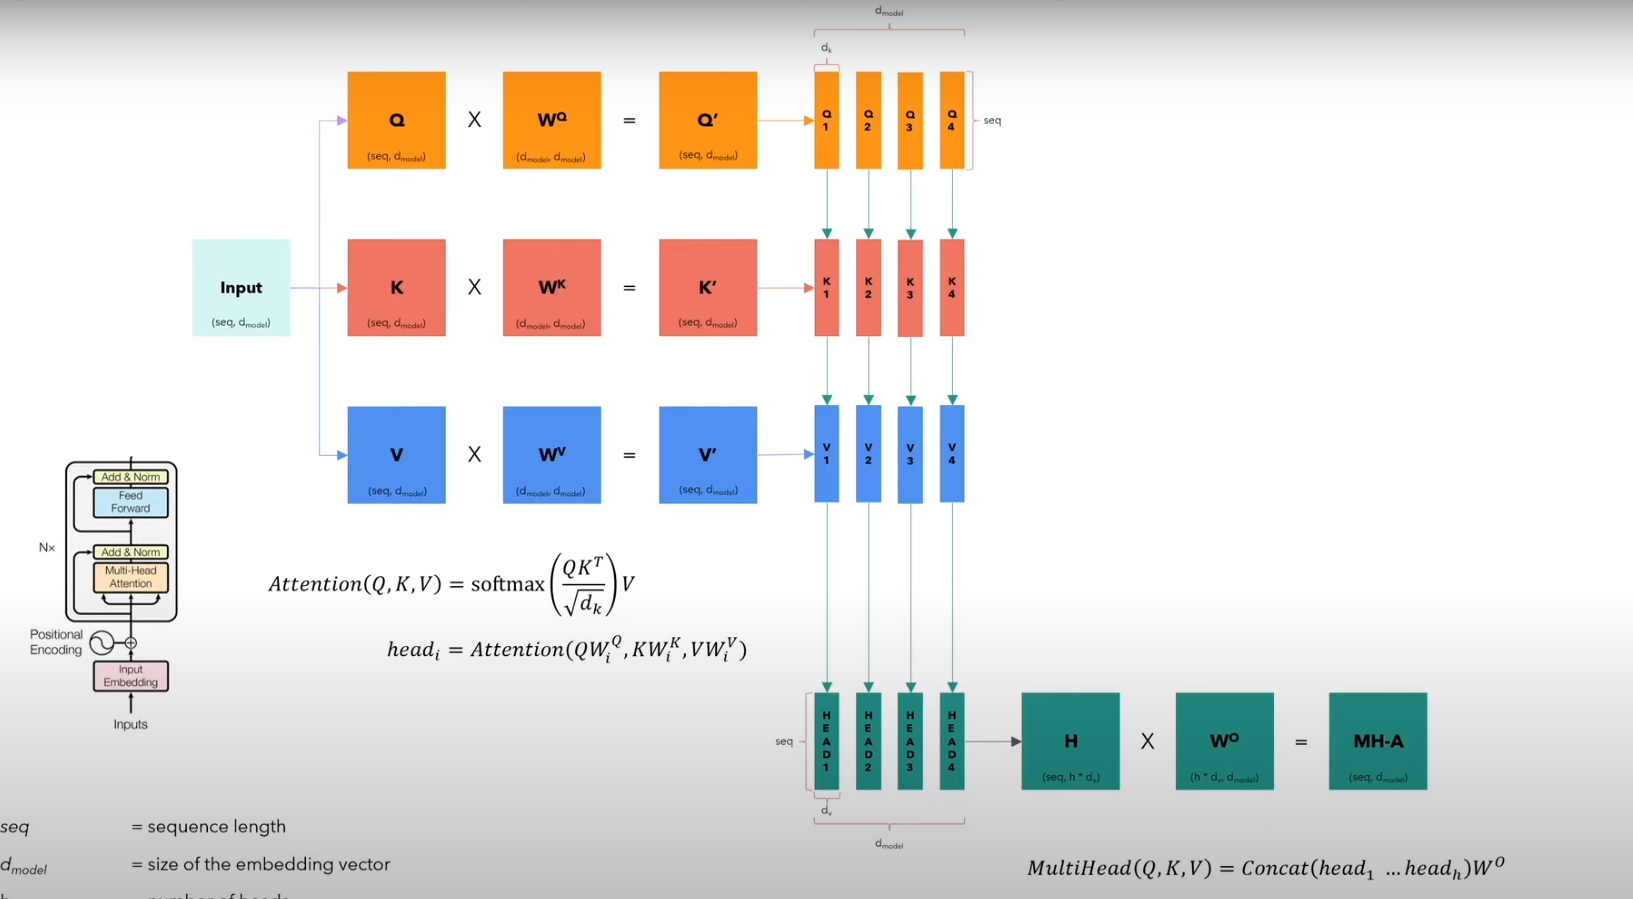

Formula used for calcualting ATTENTION.

 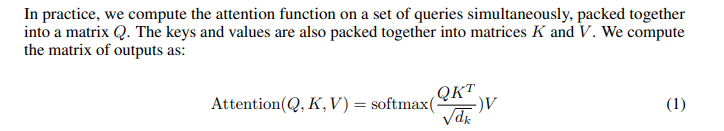

In [66]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, h: int) -> None:
        super().__init__()
        self.d_model = d_model
        self.h = h #d_model needs to be divided into h heads. 
        assert d_model % h == 0, "d_model is not divisble by h" #this makes sure that d_model is divisible by h :)
        self.d_k = d_model // h 
        
        self.w_q = nn.Linear(d_model, d_model) #this has dimension d_model by d_model so that when mutiplied later with q, the output will be seq by d_model
        self.w_k = nn.Linear(d_model, d_model)
        self.w_v = nn.Linear(d_model, d_model)
        
        self.w_o = nn.Linear(d_model, d_model) #output matrix
        self.dropout = nn.Dropout(dropout)
    
    #this step of writing static method makes sure that you do not need to provide any instance of this class and can be called separately.
    @staticmethod 
    def attention(query,key,value, mask, dropout : nn.Dropout):
        attention_scores = (query @ key.transpose(-2,-1)) / math.sqrt(d_k)
        # we also want to hide certain interactions and therefore hide them before using softmax to get the final output.
        
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        attention_scores = attention_scores.softmax(dim = -1)
        
        if dropout is not None:
            attention_scores = dropout(attention_scores)
        return (attentiom_scores @ value), attention_scores #here first one is the output and second one will be used for visualization of what our output looks like xd.
            
        
        
    def forward(self, q, k ,v, masks, dropout): #masks is used to hide those values in our output which were not related to each other and were not used to find weights for a particular vector.
        query = self.w_q(q) #going from (batch, seq, d_model) -> (batch, seq_dmodel)
        key = self.w_k(k) #going from (batch, seq, d_model) -> (batch, seq_dmodel)
        value = self.w_v(v) #going from (batch, seq, d_model) -> (batch, seq_dmodel)
        
        #now we want to divide these matrices into smaller matrices to give it into heads.
        #note that we do not want to split the sentence. We want to split the embeddings.
        #we are going from (batch, seq_len, d_model) -> (batch, seq_len, h, d_k) -> (batch, h, seq_len, d_k) and we do the same thing for all three matrices.
        #This reshaping and transposing allows for separate attention calculations for each head in a parallel manner, enhancing model's ability to capture 
        # diverse relationships within the input.
        
        query  = query.view(query.shape[0], query.shape[1],self.h, self.d_k).transpose(1,2) #this command essentially converts a query tensor into new 4 dimensioanl tensor with dimensions.
        key = key.view(key.shape[0], key.shape[1], self.h, self.d_k).transpose(1,2)
        value = value.view(value.shape[0], value.shape[1], self.h, self.d_k).transpose(1,2)
        
        #we want to two things from here. First output of softmax score and attention scores.
        x, self.attention_scores = MultiHeadAttention.attention(query, key, value, mask, self.dropout)
        
        # (batch , h, seq_len, d_k) ---> (batch, seq_len, h, d_k) ---> (batch, seq_len, d_model) --- we go back to original dimension.
        
        x = x.transpose(1,2).contiguous().view(x.shape[0],-1,self,h, self.d_k)
        
        
        # we are going from (batch, seq_len, d_model) ---> (batch, seq_len, d_model)
        return self.w_o(x)
        

Don't Sleep! Okay? 

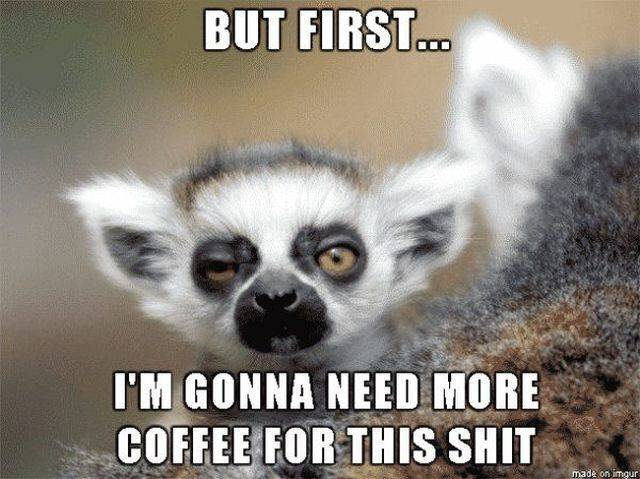

What are masks here? In encoder layer they are called source masks. 

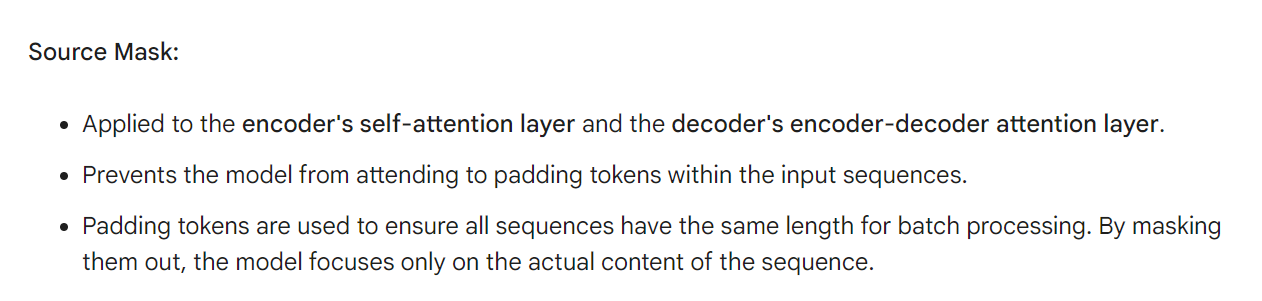

# Skip Connections



Here we implement this ADD and NORM Layer.

Sorry for this ugly marking lol. 

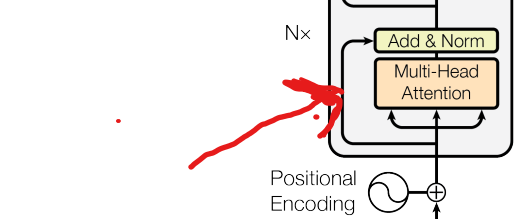

In [67]:
class ResidualConnection(nn.Module):
    def __init__(self, dropout: int) ->None:
        super().__init__()
        self.dropout = nn.Dropout()
        self.norm = LayerNormalization()
        
    def forward(self, x, sublayer):
        return x + self.dropout(sublayer(self.norm(x)))
        
        
    

# Encoder Block 

Now all of the above blocks are contained in a single block, call it Encoder Block. And the operations are performed N times in this encoder block.

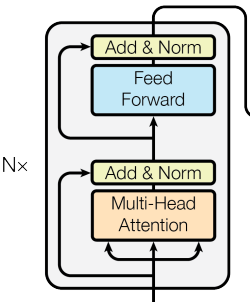

In [68]:
class EncoderBlock(nn.Module):
    def __init__(self, self_attention_block: MultiHeadAttention, feed_forward_block: FeedForwardBlock, dropout:float) -> None:
        super().__init__()
        self.self_attention_block = self_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([Residualconnection(dropout) for _ in range(2)]) # we have two skip connections as you can see in the image above. This command basically creates these two connections.
        
    def forward(self, x, src_mask):
        x = self.residual_connections[0](x, lambda x:self.self_attention_block(x,x,x,src_mask)) #this is the first connection where input is first paassed through the muti head attention block and then to the add and norm block.
        x = self.residual_connections[1](x, self.feed_forward_block) #this is the second residual block where input is passed to the feed forward block and then again to the Add and norm layer. This command creates the other upper connection as can be seen in image.
        return x

Now this block can run N number of times as discussed in the paper. Let's implement that part.


In [69]:
class Encoder(nn.Module):
    def __init__(self, layers:nn.ModuleList)-> None:
        self.layers = layers
        self.norm = LayerNormalization()
    
    def forward(self, x, mask):
        for layer in self.layers:
            x= layer(x, mask)
        return self.norm(x)
            
    #this completes the upper part in the Encoder Block which can be run N number of times. We have not combined embedding input as of now in the Encoder Block. We'll do it later.
    # the output after the N number of operations on Encoder block, will be passed to the Decoder Block.

# Decoder Block

Here also, the output embeddings will be same as input embeddings and positional encoding layer will also remain same as encoder layer. So we just need to initialise those classes again.

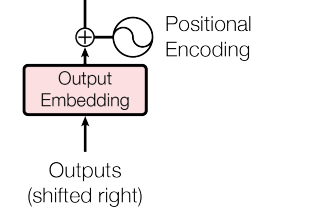

What we need to build here is the upper decoder block which involves masked multi head attention and other layers.

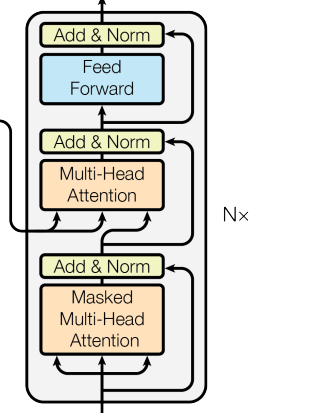

Here's simple look of two different type of attention used in Decoder Block. One is Self Attention and other is Cross Attention.

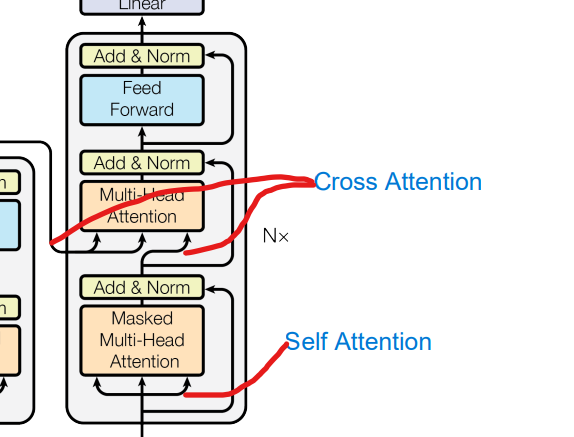


In [70]:
class DecoderBlock(nn.Module):
    def __init__(self, self_attention_block : MultiHeadAttention, cross_attention_block : MultiHeadAttention, feed_forward_block: FeedForwardBlock,dropout :float):
        super().__init__()
        self.self_attention_block = self_attention_block
        self.cross_attention_block = cross_attention_block
        self.feed_forward_block = feed_forward_block
        self.residual_connections = nn.ModuleList([ResidualConnection(dropout) for _ in range(3)])
    
    def forward(self, x, encoder_output, src_mask, tgt_mask):
        x = self.residual_connections[0](x, lambda x:self.self_attention_block(x,x,x,tgt_mask))
        x = self.residual_connections[1](x, lambda x:self.cross_attention_block(x, encoder_output, encoder_output, src_mask ))
        x = self.residual_connections[2](x, self.feed_forward_block)
        return x

Building Decoder Block to run it N times same as Encoder Layer.

In [71]:
class Decoder(nn.Module):
    
    def __init__(self, layers : nn.ModuleList) -> None:
        super().__init__()
        self.layers = layers
        self.norm = LayerNormalization()
        
    def forward(self,x, encoder_output , src_mask, tgt_mask):
        for layer in self.layers:
            x= layer(x, encoder_output,src_mask, tgt_mask)
        return self.norm(x)
    #it ends out decoder block. Now we'll move towards last stage of transformer that is Projection Layer.
    

What is Target Mask here?

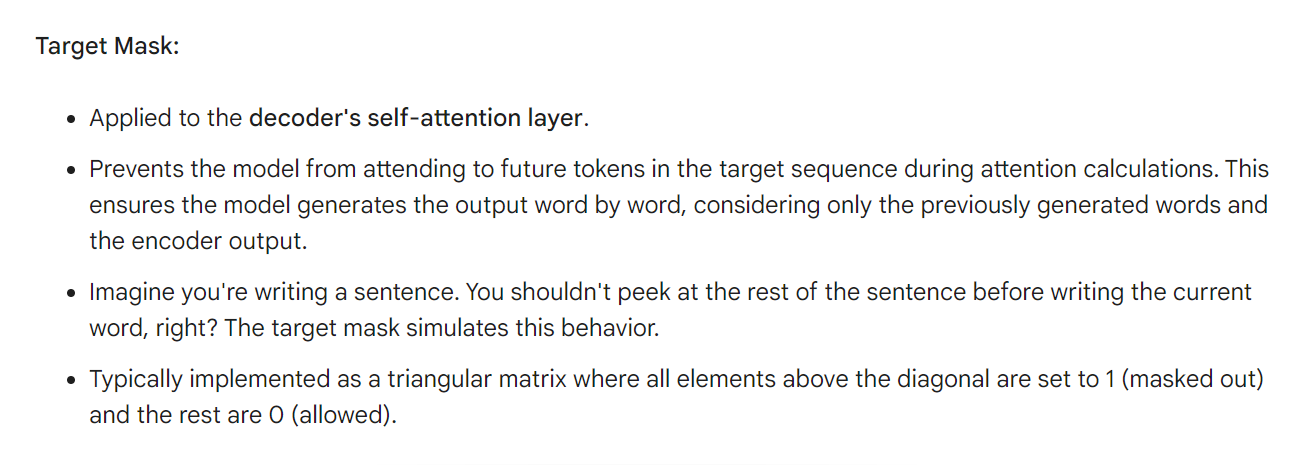



# Projection Layer

This layer projects/map the output from decoder block to those in vocabulary. 

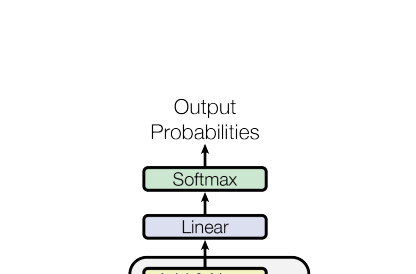

In [72]:
class ProjectionLayer(nn.Module):
    
    def __init__(self, d_model:int, vocab_size:int ) -> None:
        super().__init__()
        self.proj = nn.Linear(d_model, vocab_size) #we are basically going from size d_model to size of vocabulary. simple mapping from Decoder Blocm to Vocabulary.
    def forward(self, x):
        #we want to go from batch, seq_len, d_model to batch, seq_len, vocab_size
        return torch.log_softmax(self.proj(x), dim = -1)
    
    
        

# Transformer - Combined Layer

It's time to build our combined Transformer Architecture now :)

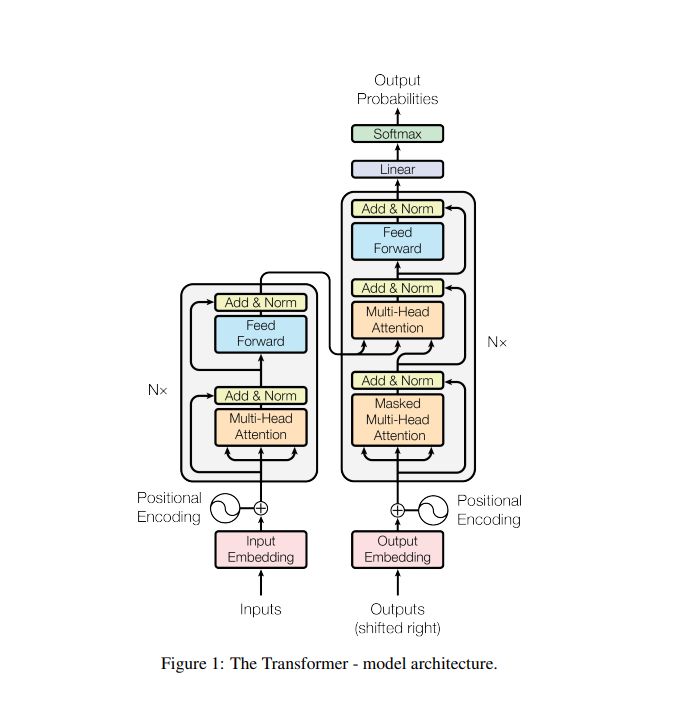

In [73]:
class Transformer(nn.Module):
    def __init__(self, encoder : Encoder, decoder = Decoder, src_embed = InputEmbeddings, tgt_embed = InputEmbeddings, src_pos = PositionalEncoding, tgt_pos = PositionalEncoding, projection_layer = ProjectionLayer) -> None:
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed  = tgt_embed
        self.src_pos = src_pos
        self.tgt_pos = tgt_pos
        self.projection_layer = projection_layer
        #now we'll define three methods. One to encode, one to decode and one to Project.
    
    def encode(self, src, src_mask):
        src = self.src_embed(src) #we first apply embeddings to the source
        src = self.src_pos(src) #then apply  positional encoding to the input 
        return self.encoder(src, src_mask) #and pass it to the encoder layer
    
    def decode(self, encoder_output, src_mask, tgt, tgt_mask):
        tgt = self.tgt_embed(tgt)
        tgt  = self.tgt_pos(tgt)
        return self.decoder(tgt, encoder_output, src_mask, tgt_mask)
    
    def project(self,x):
        return self.projection_layer(x)
    
    
        #we havent build a single block that when passed some parameters perform all the operations under the Transformers Architecture.

# Building Transformer

Now it's time to actually build a Transformer so that we can pass the parameters to run it end to end.

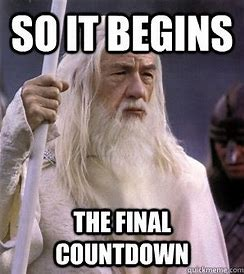

We need mutiple things here as input. 
1. Initial Vocabulary Size. 
2. Target Vocabulary Size. 
3. Source Sequence Length. 
4. Target Sequence Length. 
5. d_model. 
6. N (no. of iterations you want to have)
7. h (no. of heads)
8. dropout between 0 to 1.
9. d_ff - this is dimension of inner hidden layer



In [74]:
def build_transformer(src_vocab_size:int, tgt_vocab_size:int, src_seq_len:int, tgt_seq_len:int,
                     d_model:int = 512, N :int = 5, h:int = 8, dropout:float = 0.1, d_ff:int=2048) -> Transformer:
    
    #first we create embedding
    src_embed = InputEmbeddings(d_model, src_vocab_size)
    tgt_embed = InputEmbeddings(d_model, tgt_vocab_size)
    
    #create the positional encoding layer
    
    src_pos = PositionalEncoding(d_model,src_seq_len, dropout) #tgt_pos will be same so we might not need to create that.
    tgt_pos = PositionalEncoding(d_model, tgt_seq_len, dropout)
    
    #create the encoder blocks
    
    encoder_blocks = []
    
    for _ in range(N):
        encoder_self_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        encoder_block = EncoderBlock(encoder_self_attention_block, feed_forward_block, dropout)
        encoder_blocks.append(encoder_block)
    
    #create the decoder blocks
    
    decoder_blocks = []
    
    for _ in range(N):
        decoder_self_attention_block = MultiHeadAttention(d_model,h, dropout)
        decoder_cross_attention_block = MultiHeadAttention(d_model, h, dropout)
        feed_forward_block = FeedForwardBlock(d_model, d_ff, dropout)
        decoder_block = DecoderBlock(decoder_self_attention_block, decoder_cross_attention_block,
                                    feed_forward_block, dropout)
        decoder_blocks.append(decoder_block)
    
    encoder = Encoder(nn.ModuleList(encoder_blocks))
    decoder = Decoder(nn.ModuleList(decoder_blocks))
    
    #create the projection layer
    
    projection_layer = ProjectionLayer(d_model, tgt_vocab_size)
        
    #then we build the transformer
    
    transformer = Transformer(encoder, decoder, src_embed, tgt_embed, src_pos, tgt_pos, projection_layer)
    
    #initialise parameters so models does nor start with random values for training
    
    for p in transformer.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
            
            
    return transformer
    



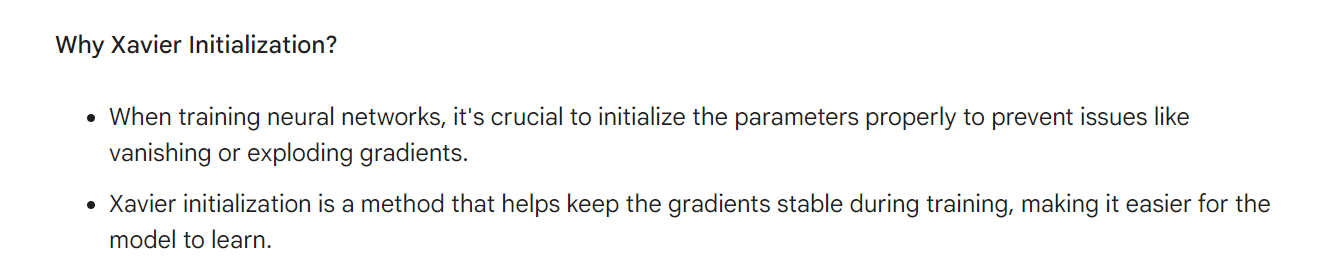

Do a big CHEERS. We just completed one of the major tasks of building whole Transformer Architecture that too from scratch.

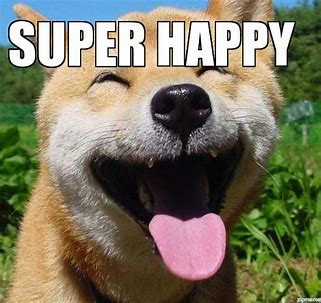

It marks the ending of our Transformer Model Code. We implemented all the parts of it's architecture, under different classes and later combined then in one to provide the output from the model. We used parameter initialization as well, to keep the gradients stable. Now we'll move towards training phase and see how we can train our transformer model.

